# Gradent-based techniques

## Saliency Map 

**idea:** A saliency map is like a heatmap that shows which parts of the input (for example, which pixels in the image or words in the sentence) were most important for model's prediction. 

Saliency maps are built by calculating gradients (how much a small change int he input changes the model's output). 


### Example using MNIST digits (images of a handwritten digits) using a basic Neural Network.

In [1]:
!pip install torch torchvision matplotlib

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

In [4]:
# build a Simple Neural Network
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(28*28, 10)  # Fully connected layer

    def forward(self, x):
        x = self.flatten(x)
        return self.fc(x)

model = SimpleCNN().to(device)

In [5]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

print("Training complete")

Epoch [1/5], Loss: 0.5393
Epoch [2/5], Loss: 0.3231
Epoch [3/5], Loss: 0.2952
Epoch [4/5], Loss: 0.2821
Epoch [5/5], Loss: 0.2736
Training complete


In [7]:
# saliency Map on One Test Image
model.eval()  # Set model to eval mode
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
images.requires_grad_()  # Enable gradients for input

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [8]:
# forward pass
outputs = model(images)
predicted_class = outputs.argmax(dim=1)

In [9]:
# Backward pass to get gradients
model.zero_grad()
outputs[0, predicted_class].backward()

In [10]:
# Saliency: gradient of output w.r.t. input
saliency = images.grad.data.abs().squeeze().cpu()

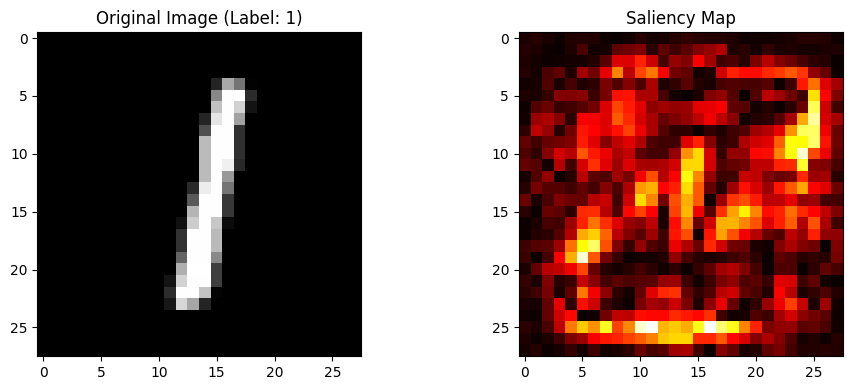

In [11]:
# Plotting the original image and its saliency map
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title(f"Original Image (Label: {labels.item()})")
plt.imshow(images[0].detach().cpu().squeeze(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Saliency Map")
plt.imshow(saliency, cmap='hot')
plt.tight_layout()
plt.show()

## Using BERT for sentiment and saliency over words (Work in progress)